Code for only running autoencoder 
#### changelog 
+ v2- successfully runnig N iterations across all combinations
+ v3- adding WT CLNZ and streamlinecode. created N indepdenent bootstrap run code to evaluate staiblity of results. packaged resample function

In [61]:
%pip install -r autoencoder_cloud_requirements.txt
%matplotlib inline
import sys
import os
import logging #to suppress pytorch GPU output etc
import warnings
#supress specific future warnings and automatic lighitning outputs
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",r".*does not have many workers which may be a bottleneck.*")
warnings.filterwarnings("ignore",".*GPU available but not used.*",category=UserWarning) # option 2: just filter out the GPU‐warning
#run import modules for analysis 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
from tqdm import tqdm
import datetime
import pickle
import sklearn
from sklearn.metrics import davies_bouldin_score
print(f"matplotlib version: {matplotlib.__version__},sns version: {sns.__version__},pandas ver: {pd.__version__}")
#torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
from torch.utils.data import TensorDataset, DataLoader
import tensorboard
from functools import partial
from joblib import Parallel, delayed 
#custom loads
from external_functions import *
from sns_plotting_config import *
from ax_modifier_functions_cloud import *

plt.style.use('paper_plot.mplstyle') ## elsevier fig sizes https://www.elsevier.com/about/policies-and-standards/author/artwork-and-media-instructions/artwork-sizing

Looking in indexes: https://download.pytorch.org/whl/nightly/cu128, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
matplotlib version: 3.7.0,sns version: 0.12.1,pandas ver: 1.5.2


In [2]:
print(os.getcwd())

G:\My Drive\Colab notebooks\lightning_studio_autoencoder


## Process Data 


#### Create dataset object for resampling in bootstrapabs

In [3]:
folder_loc = '/Run Outputs/'
date_tag = "_".join([datetime.now().strftime('%d'),datetime.now().strftime('%h'),datetime.now().strftime('%Y')])
print(f"date tag: {date_tag}")
folder_name =folder_loc+  f"figure_5_postSVM_decoding_accuracy_and_PCA_plots_"+ date_tag + "/"

date tag: 22_Jun_2025


In [69]:
# new folder structure:
# outputs/                     # For trained models and results
# │   ├── models/                  # Trained model checkpoints
# │   ├── figures/                 # Generated figures
# │   └── logs/                    # Lightning logs
    
data_folder = os.getcwd() +"/data/"
output_folder = os.getcwd() +"/output/"
model_results_folder = output_folder + "/model_results/"
current_run_output = model_results_folder + f"{date_tag}\\"
all_figure_output_folder = output_folder +"/figures/"
fig_output = all_figure_output_folder + f"{date_tag}\\"
#make folders 
make_folder(output_folder)
make_folder(all_figure_output_folder)
make_folder(fig_output)
make_folder(model_results_folder)
make_folder(current_run_output)

Created folder: G:\My Drive\Colab notebooks\lightning_studio_autoencoder/output//model_results/
Created folder: G:\My Drive\Colab notebooks\lightning_studio_autoencoder/output//model_results/22_Jun_2025\


'G:\\My Drive\\Colab notebooks\\lightning_studio_autoencoder/output//model_results/22_Jun_2025\\'

In [6]:
#declare loc/names of files to read
timeseries_loc=data_folder
load_dataset = True
save_norm_trial_dataset = True
trial_df_filename = timeseries_loc +  f"Dlx56_Normalized Trial Calcium Timeseries_20_Jun_2025.parquet"

if load_dataset:
    print(f"loading_dataset")
    trial_tseries_df_norm = pd.read_parquet(trial_df_filename)
else:
    trial_tseries_df_norm = get_normed_trial_tseries(enriched_by_stage_path,post_activity_timeseries, hyper_param_dict) #OPTIONAL- drop  timebins #drop N bins if applicable
    if save_norm_trial_dataset:
        print(f"saving {trial_df_filename}")
        trial_tseries_df_norm.to_parquet(trial_df_filename)
trial_tseries_df_norm.tail()

loading_dataset


,task_phase_vec,IA_RS_vec,corr_err_vec,trial_num,neuron_ID,name,day,geno,geno_day,-3.0s to -2.75s,...,Late_IA,Early_RS_Error,Early_RS_Correct,Late_RS,enriched_in_phase,any_enrichment,unique_ID,max_trial_val,mean_rate,active_in_trial
116370,Late_RS,RS,Correct,38,209,9_3_HET_RS3,3,HET,Het postCLNZ,0.0,...,0.0,0.0,0.0,0.0,False,1.0,9_3_HET_RS3-209,1.0,0.02,True
116373,Late_RS,RS,Correct,38,212,9_3_HET_RS3,3,HET,Het postCLNZ,0.0,...,0.0,0.0,0.0,0.0,False,2.0,9_3_HET_RS3-212,1.0,0.03,True
116374,Late_RS,RS,Correct,38,213,9_3_HET_RS3,3,HET,Het postCLNZ,0.0,...,0.0,0.0,0.0,0.0,False,0.0,9_3_HET_RS3-213,1.0,0.00,False
116375,Late_RS,RS,Correct,38,214,9_3_HET_RS3,3,HET,Het postCLNZ,0.0,...,0.0,0.0,0.0,0.0,False,0.0,9_3_HET_RS3-214,1.0,0.20,True
116376,Late_RS,RS,Correct,38,215,9_3_HET_RS3,3,HET,Het postCLNZ,0.0,...,0.0,0.0,0.0,0.0,False,0.0,9_3_HET_RS3-215,0.8,0.00,False


In [7]:
#once loaded, derive info from metadata
stage_names = sorted(trial_tseries_df_norm['task_phase_vec'].unique())#hardcode the stage_names (to not rely on the order of the 'unique() vector of the df
numeric_col = get_numeric_cols_timeseries(trial_tseries_df_norm, " to ") #in external_functions.py
# note informative stats for refernce later if necessary
subject_stage_info_df = get_subject_stage_info_df(trial_tseries_df_norm) # get subj level dfs
n_total_units = trial_tseries_df_norm.groupby(by = 'geno_day')['unique_ID'].nunique()
print(n_total_units)
subject_stage_info_df.tail()

geno_day
Het CLNZ         866
Het VEH          874
Het postCLNZ     937
WT CLNZ         1019
WT VEH          1080
Name: unique_ID, dtype: int64


,name,geno_day,task_phase_vec,unique_ID,num_enriched_units,num_units,trial_num,count_of_trials,over_5
198,9_3_HET_RS3,Het postCLNZ,Early_IA_Error,"[9_3_HET_RS3-6, 9_3_HET_RS3-9, 9_3_HET_RS3-12,...",34,179,"[3, 5]",2,"[False, False]"
199,9_3_HET_RS3,Het postCLNZ,Early_RS_Correct,"[9_3_HET_RS3-40, 9_3_HET_RS3-62, 9_3_HET_RS3-7...",9,179,"[17, 19, 21]",3,"[True, True, True]"
200,9_3_HET_RS3,Het postCLNZ,Early_RS_Error,"[9_3_HET_RS3-25, 9_3_HET_RS3-45, 9_3_HET_RS3-6...",9,179,"[18, 20]",2,"[True, True]"
201,9_3_HET_RS3,Het postCLNZ,Late_IA,"[9_3_HET_RS3-9, 9_3_HET_RS3-25, 9_3_HET_RS3-31...",15,179,"[12, 13, 14, 15, 16]",5,"[True, True, True, True, True]"
202,9_3_HET_RS3,Het postCLNZ,Late_RS,"[9_3_HET_RS3-3, 9_3_HET_RS3-130]",2,179,"[34, 35, 36, 38]",4,"[True, True, True, True]"


#### save class matrix store for loading later

In [8]:
# save store class_matrix_store
class_matrix_save_file = f"pseudopopulation_ensemble_activity_store_{date_tag}"
load_filename = data_folder + f"pseudopopulation_ensemble_activity_store_20_Jun_2025.pickle"

make_class_matrix = False
save_class_matrix = False

if make_class_matrix: ##create class matrix store
    neuron_enrichment =  trial_tseries_df_norm.groupby(['name', 'geno_day', 'neuron_ID'])[stage_names].mean().reset_index()
    phase_enrichment_by_subj = neuron_enrichment[list(stage_names) + ['name', 'geno_day']].groupby(by = ['name', 'geno_day']).sum().reset_index()
    trial_list_by_dataset= subject_stage_info_df.loc[:,['name', 'geno_day', 'task_phase_vec', 'trial_num', 'count_of_trials']]
    trial_list_by_dataset= trial_list_by_dataset[trial_list_by_dataset.count_of_trials >1]##important- threshold to take datasets with >1 trials per section (to have enough variety in neural activity)
    enrich_unit_ID_by_name_df = subject_stage_info_df.loc[:,['name', 'geno_day', 'task_phase_vec', 'unique_ID']]
    dataset_name_by_geno_day = enrich_unit_ID_by_name_df.groupby('geno_day')['name'].unique().reset_index()
    #use premade information to create new matrix
    class_matrix_store = make_dataset_matrix_store_only(stage_names, trial_tseries_df_norm, "unique_ID",
                                                enrich_unit_ID_by_name_df, 
                                                numeric_col,
                                                trial_list_by_dataset,
                                                dataset_name_by_geno_day,
                                                phase_enrichment_by_subj)
    if save_class_matrix:
        with open(class_matrix_save_file+'.pickle', 'wb') as handle:
            pickle.dump(class_matrix_store, handle, protocol=pickle.HIGHEST_PROTOCOL)
else: #if you don't make or save one, you load one 
    print(f" loading file: {load_filename}")
    with open(load_filename, 'rb') as handle:
        class_matrix_store = pickle.load(handle)

 loading file: G:\My Drive\Colab notebooks\lightning_studio_autoencoder/data/pseudopopulation_ensemble_activity_store_20_Jun_2025.pickle


In [9]:
class_matrix_store.keys()

dict_keys(['Early_IA_Correct', 'Early_IA_Error', 'Early_RS_Correct', 'Early_RS_Error', 'Late_IA', 'Late_RS'])

## Test Pytorch Lightning Autoencoder function on sample data 

#### Define pytorch lightining functions

In [10]:
## separate into function 
def return_train_test_tensorDataset(input_data, input_labels:np.array, shuffle:bool = True, test_on_train:bool = True):
    '''TO- given numpy matrices, and optional shuffle, return 2 pytorch test and train datasets in tensor format'''
    #moved from outside func to inside
    input_data = input_data.values.T #.T.values of concat matrix is to reshape mat into what scikit wants from you
    #get indices
    assert input_data.shape[0] > 0
    rng = np.random.default_rng()
    n_samples = input_data.shape[0]
    input_data_index =np.arange(0,n_samples) 
    permuted_index = rng.permutation(input_data_index)

    if test_on_train:
        if shuffle:
            train_index = permuted_index
            test_index = permuted_index
        else: #non shuffle, test set = train set
            train_index = input_data_index
            test_index = train_index
    else: #if test not == train
        if shuffle:
            train_index = permuted_index[0:n_samples//2]
            test_index = permuted_index[n_samples//2:n_samples]
        else:
            train_index = input_data_index[0:n_samples//2]
            test_index =  input_data_index[n_samples//2:n_samples]
        
    ##extract data of interest 
    train_data= torch.tensor(input_data[train_index,:], dtype=torch.float32)
    train_labels= torch.tensor(input_labels[train_index], dtype=torch.float32)
    
    test_data = torch.tensor(input_data[test_index,:], dtype=torch.float32)
    test_labels = torch.tensor(input_labels[test_index], dtype=torch.float32)
    ## consolidate into TEnsorDataset objects
    train_dataset = TensorDataset(train_data, train_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    return train_dataset, test_dataset

In [11]:
weight_decay = 1e-2
class dropout_net(nn.Module):
    def __init__(self, layer_1_input=50, bottleneck_input = 9, bottleneck_size = 2,dropout= 0):
        super().__init__()
        ### Using a bottleneck latent dimension of 2
        self.encoder = nn.Sequential(
            nn.Linear(layer_1_input,bottleneck_input),nn.Mish(),nn.Dropout(dropout),nn.Linear(bottleneck_input, bottleneck_size)) #from 250 node layer to 3D bottle neck/ latent space 
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size,bottleneck_input),nn.Mish(),nn.Linear(bottleneck_input, layer_1_input))

    def forward(self, x):      
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# define the LightningModule
class LitAutoEncoder(L.LightningModule):
    def __init__(self, dropout_net, **model_kwargs):#load/import  model 
        super().__init__()
        self.save_hyperparameters()# save hyperparameters to self.hparams
        self.model = dropout_net(**model_kwargs)# instantiate your model
        
    def configure_optimizers(self):
        #NEW using  weight decay baked into AdamW
        optimizer = optim.AdamW(self.parameters(),weight_decay = weight_decay, lr=0.0125)### Define your loss function (training criterion). tempw as at 0.0125, reset to 0.013
        return optimizer 
 # training_step of the LightningModule configure how your training routine behaves with a batch of training data:      
    def training_step(self, batch, batch_index):
        (data, target) = batch #unpack traiing data 
        output = self.forward(data) #get reconstruction output of model
        loss = F.mse_loss(output, data)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)# logs metrics for each training_step, & the average across the epoch, to the progress bar and logger
        return loss
    
    def forward(self, x):
        # here you define how to get outputs from inputs
        return self.model(x)

    def encode(self, x):
        # directly reach into the wrapped nn.Module
        return self.model.encoder(x)

In [12]:
class LossHistory(L.Callback):
    ## class used to store loss history of trainer module through callbacks to the trainer
    def __init__(self):
        super().__init__()
        self.train_losses = []

    def on_train_epoch_end(self, trainer, pl_module):        # pl_module.log(..., on_epoch=True) ensures 'train_loss' is in callback_metrics
        loss = trainer.callback_metrics.get("train_loss")
        if loss is not None: # .item() to turn it into a Python float
            self.train_losses.append(loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get("val_loss")
        if loss is not None:
            self.val_losses.append(loss.item())

In [13]:
def lightning_encode(model, test_loader):
    ### Push data into latent space without retreiving
    model.freeze()
    latent =[]
    labels = []
    # device = next(model.parameters()).device
    # print("Model is on:", device)
    for batch_idx, (data, target) in enumerate(test_loader): #target is true labels y
        latentSpace = model.encode(data)
        #store results
        latent.append(latentSpace.detach().numpy())
        labels.append(target.detach().numpy())
    return np.vstack(latent),  np.hstack(labels) # this should match the dim of latent_embeddings, so each pair of coordinates has an associated label

#### Test sample model performance on pytorch lightning

In [15]:
def resample_ensemble_stage_activity(class_matrix_store,
                                     n_frames_to_draw:int=500,
                                     ensemble:str = "",
                                     geno:str="",
                                     stages_to_resample:list  = ['Early_IA_Correct', 'Early_RS_Correct', 'Early_IA_Error', 'Early_RS_Error'],
                                     **kwargs):
    '''To iterate over specified stages and return dict containing N resampled frame for each stage. Requires 'resample_into_class_matrix'
    '''
    ensemble_resample_in_phase_dict = {}
    for class_name in stages_to_resample: #store the versions for this bootstrap run
        class_mat = resample_into_class_matrix(class_matrix_store,n_frames_to_draw,ensemble, class_name, geno)
        ensemble_resample_in_phase_dict[class_name] = class_mat
        
    return ensemble_resample_in_phase_dict

In [14]:
#check model is created normaly
test_model =  LitAutoEncoder(dropout_net)
test_model

LitAutoEncoder(
  (model): dropout_net(
    (encoder): Sequential(
      (0): Linear(in_features=50, out_features=9, bias=True)
      (1): Mish()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=9, out_features=2, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=9, bias=True)
      (1): Mish()
      (2): Linear(in_features=9, out_features=50, bias=True)
    )
  )
)

In [17]:
plot_sample_nn = True
#set sample parameters
ensemble = 'Early_IA_Correct'
geno= geno_order[0]
comparison = 'Early_IA_Correct_v_Early_RS_Correct'
#set hyperparameters for resample + NN
n_frames_to_draw= 500
BATCH_SIZE = 500
NUM_WORKERS = 4
shuffle_train= False
shuffle_test= False
if plot_sample_nn:    #tailor NN for current data
    class_0, class_1 = comparison.split("_v_") # print(class_0, class_1)
    
    ensemble_resample_in_phase_dict = resample_ensemble_stage_activity(class_matrix_store,n_frames_to_draw,ensemble, geno, stages_to_resample= stage_names)
    long_concat_matrix,long_concat_labels =fast_pack_data_local(ensemble_resample_in_phase_dict[class_0], ensemble_resample_in_phase_dict[class_1],0,1)        #returns concat_matrix, and concat_labels
    train_dataset, test_dataset= return_train_test_tensorDataset(long_concat_matrix, long_concat_labels, shuffle = True)
    n_cells = long_concat_matrix.shape[0]
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=shuffle_train,num_workers=NUM_WORKERS,persistent_workers=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=shuffle_test,num_workers=NUM_WORKERS)

In [18]:
long_concat_matrix

,0_c0,1_c0,2_c0,3_c0,4_c0,5_c0,6_c0,7_c0,8_c0,9_c0,...,490_c1,491_c1,492_c1,493_c1,494_c1,495_c1,496_c1,497_c1,498_c1,499_c1
unique_ID,,,,,,,,,,,,,,,,,,,,,
13_4_WT_RS1-2,0.0,0.0,0.0,0.0,0.8,1.0,0.0,0.8,0.0,1.0,...,0.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13_4_WT_RS1-5,0.0,0.6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13_4_WT_RS1-19,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,1.0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13_4_WT_RS1-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13_4_WT_RS1-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7_5_WT_RS1-59,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,1.0,0.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7_5_WT_RS1-93,0.0,1.0,0.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7_5_WT_RS1-107,0.0,0.8,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
##run make run 
numEpochs = 50
dropout_sample = 0.00
if plot_sample_nn:    #tailor NN for current data    
    model =  LitAutoEncoder(dropout_net, layer_1_input=n_cells,dropout = dropout_sample)### Instantiate your model
    history = LossHistory()
    trainer = L.Trainer(max_epochs=numEpochs,log_every_n_steps=1,callbacks = [history],enable_progress_bar=False)
    trainer.fit(model, train_loader);
    loss = history.train_losses
    lossDelta = round(loss[0]-loss[-1],4)
    print(f'final loss: {round(loss[-1],4)}. loss delta from epoch 1 to end: {lossDelta}. % loss decrease: {round(100*lossDelta/loss[0],2)}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | dropout_net | 2.1 K  | train
----------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


final loss: 0.0588. loss delta from epoch 1 to end: 0.0614. % loss decrease: 51.08


In [20]:
device = next(model.parameters()).device
print("Model is on:", device)

Model is on: cpu


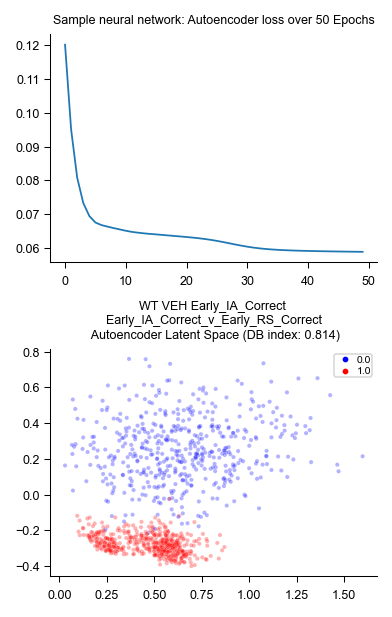

In [21]:
if plot_sample_nn:    #tailor NN for current data
    fig, ax_array = plt.subplots(2,1, figsize = (2.5,4), layout ='constrained')
    ax = ax_array[0]
    ax.plot(loss)
    ax.set_title(f'Sample neural network: Autoencoder loss over {numEpochs} Epochs')
    ### Plot latent space representation color-coded 
    ax = ax_array[1]
    with torch.no_grad():
        embed, labels =   lightning_encode(model,test_loader)##push test data throuhg encoder
    scatter = sns.scatterplot(ax = ax, x = embed[:,0], y = embed[:,1], hue =labels, palette = ['blue', 'red'], alpha = 0.3) # legend1 = ax.legend(*scatter.legend_elements()) ### according to their "true" labels
    set_labels(ax = ax, label_dict ={'title':f'{geno} {ensemble} \n{comparison}\n Autoencoder Latent Space (DB index: {round(davies_bouldin_score(embed, labels),3)})'}) #get DB index: 
    ##save fig
    fig_name = f"Sample Autoencoder ({ensemble} in {comparison})_Loss_Latent space ({numEpochs} epochs) {date_tag}"
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]

## Setup Bootstrap per NN model to get DB index of latent space

In [43]:
def train_model_get_DB_index(dropout_net, 
                             n_cells,
                            train_loader,
                            test_loader,
                            ensemble = 'Early_IA_Correct',
                            geno_day= "WT VEH",
                            comparison = 'Early_IA_Correct_v_Early_RS_Correct',
                            n_epoch = 50,
                            dropout = 0,
                            model_iter = 0):
    ''' To create B models over N epochs, then return DB index of latent space with run info appended. ''' 
    model =  LitAutoEncoder(dropout_net, layer_1_input=n_cells,dropout = dropout)### Instantiate your model
    history = LossHistory()
    trainer = L.Trainer(enable_model_summary=False, 
                        enable_progress_bar=False,
                        accelerator="cpu",    # ← force CPU
                        enable_checkpointing=False,
                        max_epochs=n_epoch,log_every_n_steps=2,callbacks = [history],)
    trainer.fit(model, train_loader);
    loss = history.train_losses #project data
    model.freeze()
    with torch.no_grad():
        embed, labels =   lightning_encode(model,test_loader)##push test data throuhg encoder
    DB_index = davies_bouldin_score(embed, labels)
        #combine/store data
    run_info = dict(model_run =model_iter, 
                    DB_index = DB_index,
                    n_epochs = n_epoch,
                    final_loss = loss[-1],
                    ensemble = ensemble,
                    geno_day= geno_day,
                    comparison = comparison,
                    lossDelta = round(loss[0]-loss[-1],4))
    return run_info

In [75]:
def make_train_model_get_DB(n_cells,
                            class_matrix_store,
                            ensemble = 'Early_IA_Correct',
                            geno_day= "WT VEH",
                            comparison = 'Early_IA_Correct_v_Early_RS_Correct',
                            n_epoch = 50,
                            n_frames_to_draw = 500,
                            dropout = 0,
                            model_run:list= [0]):
    ''' Pass in raw data to resample then build dataloaders around. Resamples B datasets for B models in bootstrap'''
    #extract and reasmple data 
    class_0, class_1 = comparison.split("_v_") # print(class_0, class_1)    
    #run B bootstraps
    run_results = []
    for b in model_run: #make sure is list to iterate over 
        ensemble_resample_in_phase_dict = resample_ensemble_stage_activity(class_matrix_store,n_frames_to_draw,ensemble, geno_day, stages_to_resample= [class_0, class_1])
        long_concat_matrix,long_concat_labels =fast_pack_data_local(ensemble_resample_in_phase_dict[class_0], ensemble_resample_in_phase_dict[class_1],0,1)        #returns concat_matrix, and concat_labels
        train_dataset, test_dataset= return_train_test_tensorDataset(long_concat_matrix, long_concat_labels, shuffle = True)
        train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=500, shuffle=False,num_workers=0,persistent_workers=False)
        test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=500, shuffle=False,num_workers=0)
        n_cells = long_concat_matrix.shape[0]
        
        bootstrap_output = train_model_get_DB_index(dropout_net, 
                                                    n_cells,
                                                    train_loader,
                                                    test_loader,
                                                    ensemble = ensemble,
                                                    geno_day= geno_day,
                                                    comparison = comparison,
                                                    n_epoch = 50,
                                                    dropout = 0,
                                                    model_iter = b)
        ##get mean activity per class of bootstrap
        class_1_mean = round(ensemble_resample_in_phase_dict[class_0].values.mean(),4)
        class_2_mean = round(ensemble_resample_in_phase_dict[class_1].values.mean(),4)
        run_info = {**bootstrap_output, 'class_1_mean': class_1_mean, 'class_2_mean': class_2_mean}
        run_results.append(run_info)
    return run_results

In [76]:

dropout_level = 0.00

partial_param_nn_train = partial(make_train_model_get_DB,
                                 n_cells = n_cells,
                                 class_matrix_store=class_matrix_store,
                                 n_epoch = 50,
                                 ensemble = 'Early_IA_Correct', 
                                 geno_day= geno_order[0],
                                 comparison = 'Early_IA_Correct_v_Early_RS_Correct',
                                 dropout = dropout_level,)
partial_param_nn_train
partial_param_nn_train(model_run=[0,1])

[{'model_run': 0,
  'DB_index': 0.7684277262091106,
  'n_epochs': 50,
  'final_loss': 0.05813608691096306,
  'ensemble': 'Early_IA_Correct',
  'geno_day': 'WT VEH',
  'comparison': 'Early_IA_Correct_v_Early_RS_Correct',
  'lossDelta': 0.0801,
  'class_1_mean': 0.1272,
  'class_2_mean': 0.0373},
 {'model_run': 1,
  'DB_index': 0.7675258980447612,
  'n_epochs': 50,
  'final_loss': 0.05768142640590668,
  'ensemble': 'Early_IA_Correct',
  'geno_day': 'WT VEH',
  'comparison': 'Early_IA_Correct_v_Early_RS_Correct',
  'lossDelta': 0.055,
  'class_1_mean': 0.1248,
  'class_2_mean': 0.0385}]

In [55]:
%%time
partial_param_nn_train(model_run=[0,1])

CPU times: total: 3.67 s
Wall time: 9.14 s


[{'model_run': 0,
  'DB_index': 0.5451891600912303,
  'n_epochs': 50,
  'final_loss': 0.0579286590218544,
  'ensemble': 'Early_IA_Correct',
  'geno_day': 'WT VEH',
  'comparison': 'Early_IA_Correct_v_Early_RS_Correct',
  'lossDelta': 0.0625,
  'class_1_mean': 0.1258,
  'class_2_mean': 0.0379},
 {'model_run': 1,
  'DB_index': 1.0570817304573767,
  'n_epochs': 50,
  'final_loss': 0.05845816060900688,
  'ensemble': 'Early_IA_Correct',
  'geno_day': 'WT VEH',
  'comparison': 'Early_IA_Correct_v_Early_RS_Correct',
  'lossDelta': 0.0739,
  'class_1_mean': 0.1268,
  'class_2_mean': 0.0382}]

In [ ]:
#record of speed on local machine
# 2 jobs, 100 iters, = 5 minutes with 500 samples/class fed in  (backend- threading)
# 5 jobs, 500 iters, = 41 minutes with 500 samples/class fed in  (backend- threading+ CPU train )
# 2 jobs, 100 iters, =  6 minutes with 500 samples/class fed in  (backend- threading + CPU train )
# 4 jobs, 100 iters, =  7.7 minutes with 500 samples/class fed in  (backend- threading + CPU train )
# 4 jobs, 100 iters, =  5 minutes with 500 samples/class fed in  (backend- Loky + CPU train )
# 10 jobs, 1000 iters, = 30 minutes with 500 samples/class fed in  (backend- Loky + CPU train )
 #14 jobs-  500 iter, elapsed: 16.5min finished
# 14 jobs, 100 iters, =  4 minutes with 500 samples/class fed in  (backend- Loky + CPU train )
# 14 jobs, 200 iters, =  6 minutes with 500 samples/class fed in  (backend- Loky + CPU train )
# 14 jobs, 300 iters, =  10 minutes with 500 samples/class fed in  (backend- Loky + CPU train )

print(f"14 jobs, 500 iterations over all data = {16*len(geno_order_w_WT_CLNZ)* 8} minutes")
print(f"4 jobs, 100 iterations over all data = {5*len(geno_order_w_WT_CLNZ)* 8} minutes")
print(f"14 jobs, 100 iterations over all data = {4*len(geno_order_w_WT_CLNZ)* 8} minutes")
print(f"14 jobs, 200 iterations over all data = {6*len(geno_order_w_WT_CLNZ)* 8} minutes")
print(f"14 jobs, 300 iterations over all data = {10*len(geno_order_w_WT_CLNZ)* 8} minutes")

In [ ]:
import psutil
#16 physical cores to use 
total_cpu_physical = psutil.cpu_count(logical=False)
print(total_cpu_physical)
n_jobs= total_cpu_physical-2

In [77]:
run_single_bootstrap = True
start_val = 0
end_val = 100
start_end_iter = make_chunked_iterator_of_ranges(start_val,end_val, n_jobs)

if run_single_bootstrap:
    print(start_end_iter)
    output_nn = Parallel(n_jobs= n_jobs, backend="loky", verbose = 9)(delayed(partial_param_nn_train)(model_run=x) for x in start_end_iter) # 10 jobs, 500 iters, = 16 minutes with 500 samples/class fed in  (backend- Loky + CPU train )
    job_records = [pd.DataFrame.from_records(x) for x in output_nn]
    bootstrap_jobs = pd.concat(job_records)
    bootstrap_jobs

N_batches: 14
Batch_size: 7
[array([0, 1, 2, 3, 4, 5, 6]), array([ 7,  8,  9, 10, 11, 12, 13]), array([14, 15, 16, 17, 18, 19, 20]), array([21, 22, 23, 24, 25, 26, 27]), array([28, 29, 30, 31, 32, 33, 34]), array([35, 36, 37, 38, 39, 40, 41]), array([42, 43, 44, 45, 46, 47, 48]), array([49, 50, 51, 52, 53, 54, 55]), array([56, 57, 58, 59, 60, 61, 62]), array([63, 64, 65, 66, 67, 68, 69]), array([70, 71, 72, 73, 74, 75, 76]), array([77, 78, 79, 80, 81, 82, 83]), array([84, 85, 86, 87, 88, 89, 90]), array([91, 92, 93, 94, 95, 96, 97]), array([98, 99])]


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of  15 | elapsed:  3.7min remaining: 24.3min
[Parallel(n_jobs=14)]: Done   4 out of  15 | elapsed:  4.1min remaining: 11.2min
[Parallel(n_jobs=14)]: Done   6 out of  15 | elapsed:  4.1min remaining:  6.1min
[Parallel(n_jobs=14)]: Done   8 out of  15 | elapsed:  4.1min remaining:  3.6min
[Parallel(n_jobs=14)]: Done  10 out of  15 | elapsed:  4.1min remaining:  2.0min
[Parallel(n_jobs=14)]: Done  12 out of  15 | elapsed:  4.1min remaining:  1.0min
[Parallel(n_jobs=14)]: Done  15 out of  15 | elapsed:  4.2min finished


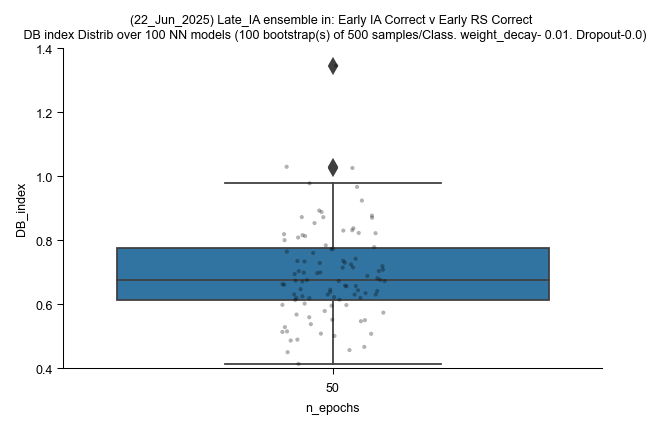

In [80]:
if run_single_bootstrap:
    DB_of_epoch = bootstrap_jobs
    #plot N NN runs
    fig,ax = plt.subplots(1,1,figsize = (4,2.75), layout = 'constrained')
    sns.boxplot(data = DB_of_epoch, x = 'n_epochs', hue = 'geno_day', y = 'DB_index', dodge = False)#showcaps=False,fliersize = 0)
    sns.stripplot(data = DB_of_epoch, x = 'n_epochs', hue = 'geno_day', y = 'DB_index', palette = ['black'], alpha = 0.3, s = 2,dodge = False)#showcaps=False,fliersize = 0)
    
    set_labels(ax, label_dict = {'legend_false':True, 'ylim': [0.4, 1.4],
        'title': f"({date_tag}) {ensemble} ensemble in: {comparison.replace("_", " ")} \n" + 
        f" DB index Distrib over {DB_of_epoch.model_run.nunique()} NN models "+ 
                                 f"({end_val} bootstrap(s) of 500 samples/Class. weight_decay- {weight_decay}. Dropout-{dropout_level})"})
    ##save fig
    fig_name =f"{DB_of_epoch.model_run.nunique()} NN runs- {ensemble} ens- DB index {end_val} Bootstrap {dropout_level} dropout_decay {weight_decay} _{date_tag}"
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]

#### Bootstrap over all combinations 

In [90]:
os.getcwd()

'G:\\My Drive\\Colab notebooks\\lightning_studio_autoencoder'

In [96]:
last_bootstrap_run = "//output//model_results//22_Jun_2025//NN 100 bootstrap_ DB index results_22_Jun_2025.parquet"
load_last_bootstrap_output = True
#set parameters 
ens_stage_pairs_subset = {'Early_IA_Correct_v_Early_RS_Correct':['Early_IA_Correct', 'Early_RS_Correct'],
                              'Early_IA_Error_v_Early_RS_Error':['Early_IA_Error', 'Early_RS_Error'],
                              'Late_IA_v_Early_RS_Correct':['Late_IA', 'Early_RS_Correct'],
                              'Early_IA_Correct_v_Late_IA':['Early_IA_Correct','Late_IA'] }
geno_plot = geno_order_w_WT_CLNZ
    
if load_last_bootstrap_output:
    bootstrap_output =pd.read_parquet(os.getcwd()+ last_bootstrap_run)
else:
    #16 physical cores to use 
    n_jobs= 14
    start_val = 0
    end_val = 100
    #input data- stage_resample_by_geno_ensemble = ensemble > geno > stage activity
    start_end_iter = make_chunked_iterator_of_ranges(start_val,end_val, n_jobs)
    print(start_end_iter)
    ## set params for loop
    dropout_level = 0.00
    bootstrap_NN = True
    ##  MAIN AUTOENC LOOP
    bootstrap_storage = []
    if bootstrap_NN:
        # 6458.94s/it | 100 min/iter for 14 jobs 300 NN bootstraps
        for comparison, ensemble_list in tqdm(ens_stage_pairs_subset.items()):            # print(f" Decoding stages {comparison} for ensembles {ensemble_list}")
            class_0, class_1 = comparison.split("_v_") # print(class_0, class_1)
            for ensemble in ensemble_list: #iterate over all ensembles(comparisons are locked to 1 per ensemble list
                for g_count, geno in enumerate(geno_plot): #iterate over geno days    
                    print(f" {comparison} - {ensemble} {geno} autoencoder run")
                    ### freeze function, creates bootstrap per run
                    partial_param_nn_train = partial(make_train_model_get_DB,
                                                     n_cells = n_cells,
                                                     class_matrix_store=class_matrix_store,
                                                     n_epoch = 50,
                                                     ensemble = ensemble, 
                                                     geno_day= geno,
                                                     comparison = comparison,
                                                     dropout = dropout_level,)
                    # ## run job in paralell 
                    output_nn = Parallel(n_jobs= n_jobs, backend="loky", verbose = 9)(delayed(partial_param_nn_train)(model_run=x) for x in start_end_iter) # 10 jobs, 500 iters, = 16 minutes with 500 samples/class fed in  (backend- Loky + CPU train )
                    #save.concat paralell output
                    job_records = [pd.DataFrame.from_records(x) for x in output_nn]
                    bootstrap_jobs = pd.concat(job_records)
                    bootstrap_storage.append(bootstrap_jobs) #list of DFs with info on B NNs created/projected
    bootstrap_output = pd.concat(bootstrap_storage)
    #save database of B shuff
    nn_bootstrap_filename  = current_run_output + f"NN {end_val} bootstrap_ DB index results_{date_tag}.parquet"
    print(f"saved bootstrap output file: {nn_bootstrap_filename}")
    bootstrap_output.to_parquet(nn_bootstrap_filename)

#regardless of choice for acquiring df, print info
print(bootstrap_output.info())
bootstrap_output.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 1
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model_run     4000 non-null   int32  
 1   DB_index      4000 non-null   float64
 2   n_epochs      4000 non-null   int64  
 3   final_loss    4000 non-null   float64
 4   ensemble      4000 non-null   object 
 5   geno_day      4000 non-null   object 
 6   comparison    4000 non-null   object 
 7   lossDelta     4000 non-null   float64
 8   class_1_mean  4000 non-null   float64
 9   class_2_mean  4000 non-null   float64
dtypes: float64(5), int32(1), int64(1), object(3)
memory usage: 328.1+ KB
None


,model_run,DB_index,n_epochs,final_loss,ensemble,geno_day,comparison,lossDelta,class_1_mean,class_2_mean
0,0,0.676560,50,0.057909,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0773,0.1251,0.0367
1,1,0.882933,50,0.058213,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0589,0.1273,0.0374
2,2,0.965442,50,0.056909,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0572,0.1216,0.0388
3,3,0.654711,50,0.057907,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0735,0.1272,0.0366
4,4,0.826431,50,0.058538,Early_IA_Correct,WT VEH,Early_IA_Correct_v_Early_RS_Correct,0.0608,0.1280,0.0371


[None, None]

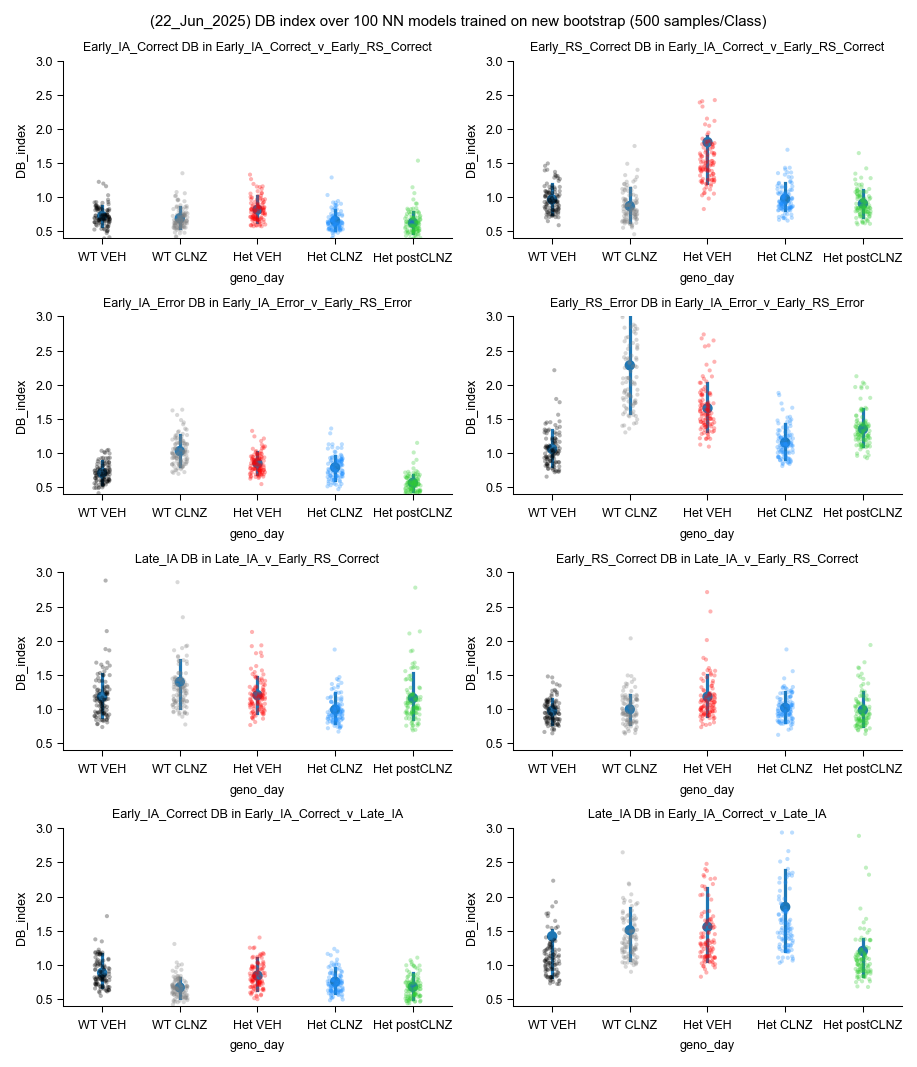

In [87]:

#plot N NN runs
fig,ax_array = plt.subplots(len(ens_stage_pairs_subset.keys()),2, figsize = (6,7), layout = 'constrained')
for c, comparison in enumerate(ens_stage_pairs_subset.keys()):
    for e, ens in enumerate(ens_stage_pairs_subset[comparison]):
        ax = ax_array[c,e]
        facet_mask = (bootstrap_output.comparison == comparison) & (bootstrap_output.ensemble ==ens)
        plot_db = bootstrap_output.loc[facet_mask, :]
        sns.pointplot(ax = ax, data = plot_db, x = 'geno_day',  y = 'DB_index', order = geno_order_w_WT_CLNZ, linestyles = 'None', dodge = False,errorbar = ('pi', 75))#showcaps=False,fliersize = 0)
        sns.stripplot(ax = ax, data =plot_db, x = 'geno_day', y = 'DB_index', **geno_order_w_WT_CLNZ_no_eb, alpha = 0.3, s = 2,dodge = False)#showcaps=False,fliersize = 0)
        set_labels(ax, label_dict = {'legend_false':True, 'ylim': [0.4, 3], 'title': f"{ens} DB in {comparison}"})
    
##save fig
fig.suptitle(f"({date_tag}) DB index over {end_val} NN models trained on new bootstrap (500 samples/Class)")
fig_name =f"{end_val} NN boostrap-  DB index with {dropout_level} dropout_decay {weight_decay} _{date_tag}"
# save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'png'])
[fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]

#### Loop autoencoder over ensembles

In [ ]:
def save_metadata_record(last_run_metadata_record:pd.DataFrame, metadata_record_filename:str, save_loc:str):
    #write filename to dF
    
    if not os.path.exists(metadata_record_filename):    #create locally then save
        print(f"creating autoencoder versioning file: {metadata_record_filename}")
        last_run_metadata_record.to_csv(metadata_record_filename,index = False)
    else: #load existing and add to it 
        print(f"Loading autoencoder versioning file: {metadata_record_filename}")
        metadata_record= pd.read_csv(metadata_record_filename)
        metadata_record = pd.concat([metadata_record, last_run_metadata_record]) #join prev df with latest DF
        #save multiple backups 
        # metadata_record.to_csv(metadata_record_filename) 
        metadata_record.to_csv(save_loc + metadata_record_filename)
        metadata_record.to_csv(csv_folder_most_recent +metadata_record_filename)
        metadata_record.to_csv(csv_folder_current_run + metadata_record_filename)


In [ ]:
print(os.getcwd())
#preset the storage output name:
torch_model_storage = f"torch_model_storage_{date_tag}\\"
print(f'saving to {torch_model_storage}')

In [59]:
run_autoencoder=False

In [ ]:
#set the dataset filters to use when making things 
ensemble_plot = ['Early_IA_Correct', 'Early_RS_Correct', 'Early_IA_Error', 'Early_RS_Error'] #what ensembles do you care about
geno_plot =  geno_order_w_WT_CLNZ
decode_plot = ['Early_IA_Correct_v_Early_IA_Error', 'Early_IA_Correct_v_Early_RS_Correct', 'Early_IA_Error_v_Early_RS_Error', 'Early_RS_Correct_v_Early_RS_Error'] #what class comparisons do you care about
run_info_list = [] #store the gathered data
## set params for current run 
run_params = dict(dropout = 0.05, numEpochs = 50,n_frames_to_draw= 500, BATCH_SIZE = 250, NUM_WORKERS = 2, test_on_train= False,lr=0.0125)#gather into run params
if run_params['test_on_train']:
    run_params['n_frames_to_draw']= run_params['n_frames_to_draw']*2
## MAIN AUTOENC LOOP
ens_stage_pairs_subset = {'Early_IA_Correct_v_Early_RS_Correct':['Early_IA_Correct', 'Early_RS_Correct'],
                          'Early_IA_Error_v_Early_RS_Error':['Early_IA_Error', 'Early_RS_Error'],
                          'Late_IA_v_Early_RS_Correct':['Late_IA', 'Early_RS_Correct'],
                          'Early_IA_Correct_v_Late_IA':['Early_IA_Correct','Late_IA'] }
save_model = True
if run_autoencoder:
    make_folder(torch_model_storage)
    
    for comparison, ensemble_list in tqdm(ens_stage_pairs_subset.items()):            # print(f" Decoding stages {comparison} for ensembles {ensemble_list}")
        class_0, class_1 = comparison.split("_v_") # print(class_0, class_1)
        for ensemble in ensemble_list: #iterate over all ensembles(comparisons are locked to 1 per ensemble list
            for g_count, geno in enumerate(geno_plot): #iterate over geno days             
                ensemble_resample_in_phase_dict = resample_ensemble_stage_activity(class_matrix_store,n_frames_to_draw,ensemble, class_name, geno, stages_to_resample= stage_names)
                long_concat_matrix,long_concat_labels =fast_pack_data_local(ensemble_resample_in_phase_dict[class_0], ensemble_resample_in_phase_dict[class_1],0,1)        #returns concat_matrix, and concat_labels
                train_dataset, test_dataset= return_train_test_tensorDataset(long_concat_matrix, long_concat_labels, shuffle = True,test_on_train = run_params['test_on_train'])
                n_cells = long_concat_matrix.shape[0]
                train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=run_params['BATCH_SIZE'],pin_memory= True, shuffle=True,num_workers=run_params['NUM_WORKERS'],persistent_workers=True)
                test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=run_params['BATCH_SIZE'],pin_memory= True, shuffle=True,num_workers=run_params['NUM_WORKERS'])
                ### Instantiate your model
                model =  LitAutoEncoder(dropout_net, layer_1_input=n_cells,dropout = run_params['dropout'])
                history = LossHistory()
                trainer = L.Trainer(max_epochs=run_params['numEpochs'],log_every_n_steps= 1,callbacks = [history],
                                    enable_checkpointing=False,enable_progress_bar= False, enable_model_summary = False)
                trainer.fit(model, train_loader)
                loss = history.train_losses #quantify and plot loss over train
                # #save info
                run_info = dict(classes_decoded = comparison, 
                                geno_day= geno,
                                ensemble = ensemble,
                                class_0 = class_0,
                                class_1 = class_1, 
                                n_frames = long_concat_matrix.shape[0],
                                num_epochs = run_params['numEpochs'], 
                                mean_loss = np.mean(loss[-10:]),
                                n_cells = n_cells, 
                                dropout = run_params['dropout'], 
                                test_on_train=run_params['test_on_train'],
                               date_run = date_tag)
                ##freeze and save model for more embeddings later
                if save_model:
                    torch.save(model.state_dict(), torch_model_storage+ f'model_{"_".join([comparison,geno,ensemble])}.pt')
                    trainer.save_checkpoint(torch_model_storage+ f'model_checkpoint_{"_".join([comparison,geno,ensemble,".ckpt"])}')
                #Test data- create embeddings 
                embed, labels = lightning_encode(model, test_loader)##push test data throuhg encoder
                embed_df = pd.DataFrame(np.hstack([embed, labels[:,np.newaxis]]), columns = ['embed_1', 'embed_2', 'labels']).assign(**run_info)       
                ##convert categories for space efficiency
                conversion_cols = dict(classes_decoded = 'category', geno_day= 'category', ensemble = 'category',class_0 = 'category', class_1 = 'category', n_frames = 'Int64',date_run = 'category',labels= 'category')
                embed_df.loc[:, list(conversion_cols.keys())] = embed_df.loc[:, list(conversion_cols.keys())].astype(conversion_cols)
                run_info_list.append(embed_df)
    #save run params 
    embed_record = pd.concat(run_info_list)
    embed_record["labels"]= np.where(embed_record["labels"] == 0.0, embed_record["class_0"], embed_record["class_1"])
    
    filename = torch_model_storage+ f"run_param_{date_tag}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(run_params, file)

In [ ]:
autoencoder_record = 'last_autoencoder_run_info.txt'
autoencoder_run_versions = f"autoencoder project- run version record.csv"
resample_type_str = {True: f"_Embed Train Data", False: f"_Embed New Data"}
#save files based on conditions
if run_autoencoder:
    #save embed record
    file_name = f"Autoencoder_latent_space_run_{date_tag}_{run_params['n_frames_to_draw']}Sample_{ run_params['numEpochs']}Epoch_{resample_type_str[run_params['test_on_train']]}"
    embed_record.to_parquet(file_name, compression='snappy')
    ## save loc of current encoder
    f = open(autoencoder_record, "w")
    autoencode_run_info_str = f"latest autoencoder output filename: {file_name}. Run end: {date_tag}. Data used: {analysis_data_to_use_folder}"
    f.write(autoencode_run_info_str)
    f.close()
    print(autoencode_run_info_str)
    ## DATA VERSIONING #create run information df
    run_info = {'run_date': date_tag, 
                'run_dataset_used': analysis_data_to_use_folder,
                'n_epoch': run_params['numEpochs'],
                'n_class_frames':run_params['n_frames_to_draw'],
                'ensembles_ran': [ensemble_plot],
                'classes_ran': [decode_plot],
                'file_name':file_name,
                'test_on_train': run_params['test_on_train'],
                'model_locations': torch_model_storage,
               'lr':0.0125}
    run_df_general = pd.DataFrame.from_dict(run_info)
    #write filename to dF
    file_loc = datasets_location
    save_metadata_record(last_run_metadata_record=run_df_general, 
                         metadata_record_filename=autoencoder_run_versions,
                         save_loc=folder_name)    
else: #if you already have an autoencoder result to open
    run_record= pd.read_csv(autoencoder_run_versions)
    f = open(autoencoder_record, "r")
    autoencode_run_txt = f.read()
    autoencode_filename = autoencode_run_txt.split(': ')[1].split('. Run')[0]
    print(autoencode_filename)
    embed_record =pd.read_parquet(timeseries_loc+ autoencode_filename)
print(run_record.iloc[-5:,:])
embed_record

#### Plot all autoencoder embeddings

In [ ]:
plot_embedding = True
if plot_embedding:
    fig = plt.figure(figsize = (5,6.5), layout = 'constrained')
    ##set plot params
    plot_df = embed_record
    compared_col = 'classes_decoded'
    ens_col = 'ensemble'
    genos_used = plot_df['geno_day'].unique()
    subfigs = fig.subfigures(len(plot_df[compared_col].unique()),1,
                             wspace = 0.01, hspace = 0.01)
    #Loop over all combinations
    for r_count, comparison in enumerate(plot_df[compared_col].unique()):
        df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
        subfigs[r_count].suptitle(f"{comparison}", fontsize = 'small')
        s_fig_ax = subfigs[r_count].subplots(2,len(genos_used))
            
        for c_count, ensemble in enumerate(df_comparison[ens_col].unique()):
            df_ens_comparison = df_comparison.loc[df_comparison[ens_col]== ensemble, : ]
            
            for g_count, g in enumerate(genos_used):
                ax = s_fig_ax[c_count,g_count]
                #get info about current panel 
                df_ens_comparison_geno = df_ens_comparison.loc[(df_ens_comparison.geno_day == g),:]
                n_units = df_ens_comparison_geno.n_cells.unique()[0]
                plot_labels =  df_ens_comparison_geno.labels.unique()
                #plot projection
                class_1_data =  df_ens_comparison_geno.loc[ df_ens_comparison_geno.labels== plot_labels[0],:]
                class_2_data =   df_ens_comparison_geno.loc[ df_ens_comparison_geno.labels== plot_labels[1],:]
                alpha =.4
                line_width = 0.45
                n_to_plot= 200 #NEW- how many points to plot
                sc = sns.scatterplot(data =class_1_data.iloc[0:n_to_plot,:],ax =ax, x= "embed_1", y= "embed_2",  palette=['red'],hue= 'labels',legend = False, s= 3, alpha = alpha, linewidth = line_width,edgecolor = 'red', marker = 'o')
                sc = sns.scatterplot(data =class_2_data.iloc[0:n_to_plot,:],ax =ax, x= "embed_1", y= "embed_2",  palette=['blue'],hue= 'labels',legend = False, s= 3, alpha = alpha,linewidth = line_width,edgecolor = 'blue', marker = 'o')
                [x.set_facecolor('none') for x in ax.get_children() if type(x)==matplotlib.collections.PathCollection]
                #plot centroids
                set_ax_title_xlabel_ylabel(ax, label_dict = {'title': f"{ensemble} ens.\n{g} {n_units} cells",
                                                             'ylabel': None, 'xticks': [], 'yticks':[], 'xlabel':None})
    ##save fig
    fig_name = f"{date_tag} Autoencoder- Ensemble latent space"
    fig.suptitle(fig_name + f" ({n_to_plot} samples plotted")
    save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
        [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
's_4', filetypes_to_save = ['png'])

In [ ]:
os.getcwd()

## Bootstrap density score- embedded

In [ ]:
saved_model_storage = run_record.model_locations.iloc[-1] #get file location of last known run  
print(f"accessing models in {saved_model_storage}")
print(os.getcwd())
print("\\".join([timeseries_loc,saved_model_storage]))

In [ ]:
run_latent_embedding_sample= False

ensemble_plot = ['Early_IA_Correct', 'Early_RS_Correct', 'Early_IA_Error', 'Early_RS_Error']
geno_plot =  geno_order
decode_plot = ['Early_IA_Correct_v_Early_IA_Error', 'Early_IA_Correct_v_Early_RS_Correct', 'Early_IA_Error_v_Early_RS_Error', 'Early_RS_Correct_v_Early_RS_Error']
run_info_list = []

#### Run bootstrap projections and/or load previous bootstrap projections

In [ ]:
def set_bootstrap_index_every_N_rows(input_df:pd.DataFrame = pd.DataFrame(),
                                     input_filter= ['classes_decoded','ensemble','geno_day'],
                                     n_class_samples:int = 400, 
                                     bootstrap_col_name:str = 'strap'):
    ''' To get every N rows (default N = 400) and assign to a bootstrap index'''
    grouped_df = []
    for group_key, group_df in input_df.groupby(by = input_filter):
        grouped_df.append(group_df.assign(
            **{bootstrap_col_name: group_df.reset_index().index.values//n_class_samples}))
    grouped_df = pd.concat(grouped_df)
    return grouped_df

def balance_labels_of_bootstrap(df:pd.DataFrame, labels:list = [0,1], **kwargs):
    '''' to get label 1 df and label 2 df, recombine then export'''
    ##get labels == 0 df, then labels == 1
    df_1 = df[df['labels'] == labels[0]]
    df_2 = df[df['labels'] == labels[1]]
    # add bootstrap index
    group_df_1 = set_bootstrap_index_every_N_rows(df_1, **kwargs)
    group_df_2 =set_bootstrap_index_every_N_rows(df_2, **kwargs)
    #recombine into bootstrap projections df
    balanced_df = pd.concat([group_df_1,group_df_2], ignore_index=True)
    return balanced_df

In [ ]:
print(f"saved_model_storage: {saved_model_storage}")

In [ ]:
np.arange(1)

In [ ]:
##create main projection loop- do one single GPU pass then posthoc breakup
bootstrap_projections = True
bootstrap_iterations = 5 #for B ni bootstrap iterations- run entire system over again 
print(f"Pseudo-Bootstrapping (single run then divided posthoc into bootstraps).")
n_to_bootstrap= 500 #number of bootstraps to perform
n_class_samples = 400 #the size of the unit of analysis to make for each class
bootstrap_len = n_class_samples*2 #total length of each bootstrap in frames
#total number of frames to draw for each class 
n_frames_to_draw = n_class_samples*n_to_bootstrap  #to draw B bootstraps worth of data 
print(f" total N frames per class over all bootstraps: {n_frames_to_draw}")
BATCH_SIZE =bootstrap_len
NUM_WORKERS = 10
feed_full_data = False
## MAIN AUTOENC LOOP
ens_stage_pairs_subset = {'Early_IA_Correct_v_Early_RS_Correct':['Early_IA_Correct', 'Early_RS_Correct'],
                          'Early_IA_Error_v_Early_RS_Error':['Early_IA_Error', 'Early_RS_Error'],
                          'Late_IA_v_Early_RS_Correct':['Late_IA', 'Early_RS_Correct'],
                          'Early_IA_Correct_v_Late_IA':['Early_IA_Correct','Late_IA'] }
genos_to_bootstrap = geno_order_w_WT_CLNZ
bootstrap_projections_df =[]
#bootstrap within geno-ensemble loop, to only load model 1x
if bootstrap_projections:
    for comparison,ensemble_subset in tqdm(ens_stage_pairs_subset.items()):
        class_0, class_1 = comparison.split("_v_") # print(class_0, class_1)
        for ensemble,geno in tqdm(itertools.product(ensemble_subset,genos_to_bootstrap)): #iterate over all ensembles x geno day(comparisons are locked to 1 per ensemble list
            ## load NN for projection
            model_to_load_path = saved_model_storage+ f'model_{"_".join([comparison,geno,ensemble])}.pt' # print(f'loading model at {model_to_load_path}')
            old_model = torch.load(model_to_load_path, weights_only = True)
            model_layers = [k for k in old_model.keys()] #note- match size of dropout net to loaded dict 
            n_inputs = old_model[model_layers[0]].shape[1]
            # update keys by dropping `auto_encoder.`
            for key in list(old_model): ##NEW- given pytorch lightning model origin, pop unecessary prefix
                old_model[key.replace("model.", "")] = old_model.pop(key)
            ##match model architecture- load to GPU
            model_recreate = dropout_net(layer_1_input=n_inputs) #declare model
            model_recreate.load_state_dict(old_model) # load_state_dict() function takes a dictionary object, NOT a path to a saved object.
            model_recreate.to(device) # the .cuda() call puts the model onto the GPU for training
            model_recreate.eval()
            #bootstrap over B entries
            for B in tqdm(np.arange(bootstrap_iterations)): #repeat entire process B times 
                ## make data 
                ensemble_resample_in_phase_dict = resample_ensemble_stage_activity(class_matrix_store,n_frames_to_draw,ensemble, geno, stages_to_resample= stage_names)
                # ensemble_resample_in_phase_dict = {}    #store resample for this bootstrap run
                # for class_name in [class_0, class_1]: #only generate classes of interest
                #     class_mat = resample_into_class_matrix(class_matrix_store,n_frames_to_draw,ensemble,class_name,geno)
                #     ensemble_resample_in_phase_dict[class_name] = class_mat
                class_mat_0 = ensemble_resample_in_phase_dict[class_0]
                class_mat_1 = ensemble_resample_in_phase_dict[class_1]
                long_concat_matrix,long_concat_labels =fast_pack_data_local(class_mat_0,class_mat_1,0,1)        #returns concat_matrix, and concat_labels
                # #shuffle the input            # shuffle_data = long_concat_matrix[:,perm_index]             # shuffle_labels = long_concat_labels[:,perm_index]
                shuffle_input = True
                train_dataset, test_dataset= return_train_test_tensorDataset(long_concat_matrix,long_concat_labels, shuffle = shuffle_input,test_on_train = True) #push test set through network
                test_loader = torch.utils.data.DataLoader(test_dataset,
                                                          batch_size=BATCH_SIZE,
                                                          pin_memory= True, 
                                                          shuffle=shuffle_input,
                                                          num_workers=NUM_WORKERS)
                embed, labels = encode(model_recreate, device, test_loader)# with torch.no_grad():#comment out because performed in lighting function
                ##store infromation about run results- single run that's then averaged across
                run_info = dict(classes_decoded = comparison, 
                                geno_day= geno, 
                                ensemble = ensemble,
                                class_0 = class_0, 
                                class_1 = class_1, 
                                n_frames = long_concat_matrix.shape[1],
                               shuffle_input = shuffle_input,
                               date_created = date_tag,
                               loop_iteration= B)
                
                embed_df = pd.DataFrame(np.hstack([embed, labels[:,np.newaxis]]), columns = ['embed_1', 'embed_2', 'labels']).assign(**run_info)                
                embed_df['bootstrap_group'] = (embed_df.reset_index().index.values)//bootstrap_len #add 1 to allow for bootstrap len to hit e.g. 400 at the 400th mark, not 401st element
                ##convert categories for space efficiency
                conversion_cols = dict(classes_decoded = 'category', geno_day= 'category', ensemble = 'category',class_0 = 'category', class_1 = 'category', n_frames = 'Int64',date_created = 'category',labels= 'category',loop_iteration='Int8')
                embed_df.loc[:, list(conversion_cols.keys())] = embed_df.loc[:, list(conversion_cols.keys())].astype(conversion_cols)
                #update tally for every N values where N = 2 * number of class samples 
                embed_df= balance_labels_of_bootstrap(embed_df)
                bootstrap_projections_df.append(embed_df)
    #join all outputs, overwriting list storage for memory saving
    bootstrap_projections_df = pd.concat(bootstrap_projections_df).reset_index()

In [ ]:
embed_df.info()

In [ ]:
##Save and/or load parquet file
# bootstrap_projections = True
auto_load_last_run = True
autoencoder_density_record = timeseries_loc+  'last_autoencoder_density_run_info.txt'
autoencoder_DB_run_versions = f"Autoencoder bootstrap for DB index- run version record.csv"

#save the N bootstrap projection into saved latent space for DB index calculation
manual_file_to_load = "autoencoder_bootstrap_projection_23_Mar_2025_500_bootstrap.parquet"
# manual_file_to_load = "autoencoder_bootstrap_projection_15_Jun_2025_1000_bootstrap.parquet"

projection_filename = f"autoencoder_bootstrap_projection_{date_tag}_{n_to_bootstrap}_bootstrap.parquet"
if bootstrap_projections:
    bootstrap_projections_df.to_parquet(timeseries_loc+ projection_filename)  ## save loc of current encoder
    f = open(autoencoder_density_record, "w")
    autoencode_run_info_str = f"latest autoencoder bootstrap for DB Index table filename: {projection_filename}. Run end: {date_tag}. Data used: {analysis_data_to_use_folder}"
    print(autoencode_run_info_str)
    f.write(autoencode_run_info_str)
    f.close()
## save metatdata of current run ## DATA VERSIONING #create run information df
    run_info = {'run_date': date_tag, 
                'run_dataset_used': analysis_data_to_use_folder,
                'batch_size': BATCH_SIZE,
                'n_class_frames':n_frames_to_draw,
                'ensembles_ran': [ensemble_plot],
                'classes_ran': [decode_plot],
                'autoencoder_DB_bootstrap_filename':projection_filename,
                'test_on_train': True,
                'shuffle_input':shuffle_input,
                'model_storage_loc': saved_model_storage,
                'total_bootstrap_iters':bootstrap_iterations,
               }
    run_df_general = pd.DataFrame.from_dict(run_info)
    #write filename to dF
    file_loc = datasets_location
      # #write filename to dF
    save_metadata_record(last_run_metadata_record=run_df_general, 
                         metadata_record_filename=autoencoder_DB_run_versions,
                         save_loc=folder_name)
else:
    load_txt = False
    if auto_load_last_run:
        #autoload last txt file
        if load_txt:    
            f = open(autoencoder_density_record, "r")
            autoencode_run_txt = f.read()
            print(autoencode_run_txt)
            autoencoder_DB_bootstrap_filename = autoencode_run_txt.split(': ')[1].split('. Run')[0]
            f.close()
        else: #else, take from last row of run record
            print(f"loading: {autoencoder_DB_run_versions}")
            DB_bootstrap_run_record= pd.read_csv(autoencoder_DB_run_versions)# read record of DB projection metadata
            autoencoder_DB_bootstrap_filename =DB_bootstrap_run_record['autoencoder_DB_bootstrap_filename'].iloc[-1]
        #regardless of method (txt or read last line of DF), import dataset
        bootstrap_projections_df =pd.read_parquet(timeseries_loc+ autoencoder_DB_bootstrap_filename).rename({'geno': 'geno_day'},axis = 1)
    else:
        print(f"loading: {manual_file_to_load}")
        autoencoder_DB_bootstrap_filename= manual_file_to_load
        bootstrap_projections_df =pd.read_parquet(timeseries_loc+autoencoder_DB_bootstrap_filename ).rename({'geno': 'geno_day'},axis = 1)
        
bootstrap_projections_df

In [ ]:
class_bal = bootstrap_projections_df.groupby(by = ['classes_decoded', 'geno_day', 'bootstrap_group'])['labels'].value_counts().to_frame().rename({'labels': 'count'},axis = 1)
class_bal

#### DIG INTO DIFFERENCES BETWEEN MARCH AND JUNE RUN

In [ ]:
#saved march run likely was from march 20 2025 as that is last saved set 

In [ ]:
compare_march_june_models= False
if compare_march_june_models:
    march_model_store = "torch_model_storage_20_Mar_2025/"
    june_model_store = "torch_model_storage_13_Jun_2025/"
    march_model_store
    
    model_store = {'march':dict(), 'june': dict()}
    for comparison,ensemble_subset in tqdm(ens_stage_pairs_subset.items()):
            class_0, class_1 = comparison.split("_v_") # print(class_0, class_1)
            
            for ensemble,geno in tqdm(itertools.product(ensemble_subset,geno_order)): #iterate over all ensembles x geno day(comparisons are locked to 1 per ensemble list
                ## load NN for projection- OLD 
                model_to_load_path = march_model_store+ f'model_{"_".join([comparison,geno,ensemble])}.pt' # print(f'loading model at {model_to_load_path}')
                model_store['march'][(comparison,ensemble,geno)]  =  torch.load(model_to_load_path, weights_only = False)
                #load june
                model_to_load_path = june_model_store+ f'model_{"_".join([comparison,geno,ensemble])}.pt' # print(f'loading model at {model_to_load_path}')
                model_store['june'][(comparison,ensemble,geno)]  =  torch.load(model_to_load_path, weights_only = False)
                

In [ ]:

def get_embed_single_score(embed_df, 
                           ensemble_subset,
                           geno_order,
                           score_type = 'Davies-Bouldin index', **kwargs):
    ''' return SINGLE score of input data. default is DB index. loops over all genos'''
    score_list = []
    for ensemble,geno in itertools.product(ensemble_subset,geno_order):
        ensemble_mask = embed_df['ensemble']==ensemble
        geno_mask = embed_df['geno_day']==geno
        score_label_df =   embed_df.loc[geno_mask & ensemble_mask,:].copy()    
        #load from new copy
        X =score_label_df.loc[:,['embed_1','embed_2']].values
        labels =  score_label_df.loc[:,"labels"].values
        if score_type == 'Davies-Bouldin index':# lower Davies-Bouldin index =  model with better cluster separation # yields mean ‘similarity’ between clusters,
            score_label_df['Davies-Bouldin index']=davies_bouldin_score(X,labels)
        if score_type == 'silhouette_score':
            score_label_df['silhouette_score']=silhouette_samples(X,labels)
        ##Join all metrics together
        score_label_df = score_label_df.assign(comparison=comparison,geno_day=geno).set_index(['comparison','ensemble'])
        score_list.append(score_label_df)
    return pd.concat(score_list)


In [ ]:
if compare_march_june_models:
    model_keys = list(model_store['june'].keys())
    model_store['june'][model_keys[0]]

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# #
# # default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('runs/DB')

# %load_ext tensorboard 

# %tensorboard --logdir=runs#http://localhost:6006

#### Check spread by bootstrap iteration

In [ ]:
bootstrap_projections_df.info()

In [ ]:
bootstrap_projections_df

In [ ]:
bootstrap_density_runs = bootstrap_projections_df.groupby(by = ['classes_decoded', 'geno_day', 'ensemble','strap', 'loop_iteration'])[['embed_1', 'embed_2','labels']].apply(compute_dbi) #1min 15s ± 2.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

bootstrap_density_runs

In [ ]:
print(bootstrap_density_runs.info())

In [ ]:
bootstrap_density_runs.index.rename({'classes_decoded':'comparison'},inplace = True)
mean_density = bootstrap_density_runs.reset_index(level=[1,3]) #need to reset/drop as index: geno_day, bootstrap #
mean_density

#### Plot density score per bootstrap

In [ ]:
unique_comparisons = list(set(mean_density.index.get_level_values('comparison')))
unique_comparisons

In [ ]:
score_df = mean_density
score_type = 'Davies-Bouldin index'
comparison =unique_comparisons[0]
comparison_df =score_df.loc[comparison,:]
ensemble_subset = list(set(comparison_df.index.get_level_values('ensemble')))
print(ensemble_subset)
comparison_df


In [ ]:
fig_dims = dict(ncols=2,nrows = len(unique_comparisons))
ylim_list = [[0.4,2],
             [0.4,2],
             [0.5,5.5],
            [0.4,2]]
fig,ax_array = plt.subplots(**fig_dims,figsize = (7,6.5),sharey= False,layout = 'constrained')
for c, comparison in enumerate(unique_comparisons):
    comparison_df =score_df.loc[comparison,:]
    ensemble_subset = list(set(comparison_df.index.get_level_values('ensemble')))

    for e,ensemble in enumerate(ensemble_subset): #iterate over ensembles
            plot_score =comparison_df.loc[ensemble,:].reset_index()
            
            plot_ax = ax_array[c,e]
            plot_params = dict(data = plot_score, x = 'geno_day', y =score_type, order = geno_order_w_WT_CLNZ, dodge = True,
                               hue = 'loop_iteration')# palette = color_list,  hue_order = geno_order,  hue = 'geno_day')
            sc = sns.boxplot(ax =plot_ax, **plot_params, )#errorbar = ('pi',75), )
            # plot_ax.get_legend().remove()    
            ax_title = f"{ensemble.replace("_", " ")} ensemble:\n{comparison.replace("_", " ")} latent space\n {score_type} (1 Boxplot = 1 indep. 500 bootstrap loop)"
            set_labels(ax =plot_ax, label_dict = {'title': ax_title, 'legend_false': True , 'xlabel': None,})

fig.suptitle(f"({date_tag}) Stage Activity DB Index in Autoencoder latent space. Hue represents each of 5 independent full bootstrap runs ({n_class_samples} samples/class, {n_to_bootstrap} iterations/run)")
fig_name = f"Autoencoder DB Index in 5 diff bootstrap distrib {date_tag}"
save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
's_4', filetypes_to_save = ['png','svg'])

In [ ]:

fig_dims = dict(ncols=2,nrows = mean_density.reset_index().comparison.nunique())
fig,ax_array = plt.subplots(**fig_dims, figsize = (2.5*fig_dims['ncols'], 2*fig_dims['nrows']), sharey= False,
                             layout = 'constrained')
score_df = mean_density
score_type = 'Davies-Bouldin index'
posthoc_list = []
ylim_list = [[0.4,2],
             [0.4,2],
             [0.5,5.5],
            [0.4,2]]
#iterate over comparisons
for c, comparison in enumerate(mean_density.reset_index().comparison.unique()):
    comparison_df =score_df.loc[comparison,:]
    ensemble_subset = list(set(comparison_df.index.get_level_values('ensemble')))
    for e,ensemble in enumerate(ensemble_subset): #iterate over ensembles
        plot_score =comparison_df.loc[ensemble,:]
        
        plot_ax = ax_array[c,e]
        plot_params = dict(data = plot_score, x = 'geno_day', y =score_type,
                           order = geno_order_w_WT_CLNZ, **format_no_eb_w_WT_CLNZ,)# palette = color_list, order = geno_order, hue_order = geno_order,  hue = 'geno_day')
        sc = sns.pointplot(ax =plot_ax, errorbar = ('pi',75),dodge = False, **plot_params)
        # plot_ax.get_legend().remove()    
        ax_title = f"{ensemble.replace("_", " ")} ensemble:\n{comparison.replace("_", " ")} latent space\ncluster {score_type} (75ile PI)"
        set_labels(ax =plot_ax, label_dict = {'title': ax_title, 'legend_false': True , 'xlabel': None,'ylim': ylim_list[c]})
        ## plot stat annotate
        posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, sc, comparison_list_w_WT_CLNZ, 
                                                               test_name = 'cohen_d',ax_var_is_hue=True,detect_error_bar = True)
        plot_sig_bars_w_comp_df_tight(plot_ax, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.02,offset_constant=0.015) 
        comparison_name=f"{ensemble.replace("_", " ")} ensemble:\n{comparison.replace("_", " ")} latent space"
        posthoc_list.append(posthoc_df.assign(comparison=   comparison_name))
        
    
posthoc_df = pd.concat(posthoc_list)
##save fig & CSV
fig_name = f"Autoencoder-{comparison}_for {"_".join(ensemble_subset)} ensemble_ DB index"
fig.suptitle(f"Autoencoder DB index for latent space projections of \n{autoencoder_DB_bootstrap_filename}")
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="4",fig_name,csv_folder_most_recent, csv_folder_current_run,
                                csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
's_4', filetypes_to_save = ['png','svg'])



#### Find density score posthoc for N bootstraps in latent space

In [ ]:
bootstrap_density = bootstrap_projections_df.groupby(by = ['classes_decoded', 'geno_day', 'ensemble','strap'])[['embed_1', 'embed_2','labels']].apply(compute_dbi) #1min 15s ± 2.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
bootstrap_density

In [ ]:
bootstrap_density.index.rename({'classes_decoded':'comparison'},inplace = True)
mean_density = bootstrap_density.reset_index(level=[1,3]) #need to reset/drop as index: geno_day, bootstrap #
mean_density

#### DB index summary by index X stage projection

In [ ]:

fig_dims = dict(ncols=2,nrows = mean_density.reset_index().comparison.nunique())
fig,ax_array = plt.subplots(**fig_dims, figsize = (2.5*fig_dims['ncols'], 2*fig_dims['nrows']), sharey= False,
                             layout = 'constrained')
score_df = mean_density
score_type = 'Davies-Bouldin index'
posthoc_list = []
ylim_list = [[0.4,2],
             [0.4,2],
             [0.5,5.5],
            [0.4,2]]
#iterate over comparisons
for c, comparison in enumerate(mean_density.reset_index().comparison.unique()):
    comparison_df =score_df.loc[comparison,:]
    ensemble_subset = comparison_df.reset_index().ensemble.unique()
    for e,ensemble in enumerate(ensemble_subset): #iterate over ensembles
        plot_score =comparison_df.loc[ensemble,:]
        
        plot_ax = ax_array[c,e]
        plot_params = dict(data = plot_score, x = 'geno_day', y =score_type,
                           order = geno_order_w_WT_CLNZ, **format_no_eb_w_WT_CLNZ,)# palette = color_list, order = geno_order, hue_order = geno_order,  hue = 'geno_day')
        sc = sns.pointplot(ax =plot_ax, errorbar = ('pi',75),dodge = False, **plot_params)
        # plot_ax.get_legend().remove()    
        ax_title = f"{ensemble.replace("_", " ")} ensemble:\n{comparison.replace("_", " ")} latent space\ncluster {score_type} (75ile PI)"
        set_labels(ax =plot_ax, label_dict = {'title': ax_title, 'legend_false': True , 'xlabel': None,'ylim': ylim_list[c]})
        ## plot stat annotate
        posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, sc, comparison_list_w_WT_CLNZ, 
                                                               test_name = 'cohen_d',ax_var_is_hue=True,detect_error_bar = True)
        plot_sig_bars_w_comp_df_tight(plot_ax, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.02,offset_constant=0.015) 
        comparison_name=f"{ensemble.replace("_", " ")} ensemble:\n{comparison.replace("_", " ")} latent space"
        posthoc_list.append(posthoc_df.assign(comparison=   comparison_name))
        
    
posthoc_df = pd.concat(posthoc_list)
##save fig & CSV
fig_name = f"Autoencoder-{comparison}_for {"_".join(ensemble_subset)} ensemble_ DB index"
fig.suptitle(f"Autoencoder DB index for latent space projections of \n{autoencoder_DB_bootstrap_filename}")
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="4",fig_name,csv_folder_most_recent, csv_folder_current_run,
                                csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
's_4', filetypes_to_save = ['png','svg'])

In [ ]:
comparison_df

####  Figure- Cluster density in latent space subsets

#### Latent space-IA v RS Correct 

In [ ]:
def plot_db_index_by_ensemble(ax_array, comparison, ensemble_subset, score_df: pd.DataFrame, ylim:list= None,**kwargs):
    """
    Plots ensemble comparison using seaborn pointplot, annotates statistical significance, and appends posthoc results to a provided list.
    Parameters:
    - ensemble_subset (list): List of ensemble identifiers to plot.
    - score_df (pd.DataFrame): DataFrame containing the scores.
    - comparison (str): Identifier for the comparison condition.
    - color_list (list): Colors for plotting.
    - geno_order (list): Order of genotypes for consistent plotting.
    - ax_array (array-like): Array of matplotlib axes to use for subplots.
    - preset_comparison_list (list): Pairs or groups for statistical comparison.
    Returns:
    - - posthoc_list (list): External list to store posthoc result DataFrames. 
    """
    posthoc_list= []
    score_type = 'Davies-Bouldin index'
    #default args
    fig_suptitle = f"{comparison.replace("_", " ").replace(" v ", " & ")}\n stage activity separation"
    # fig_suptitle = f"Separation of activity in\n{comparison.replace("_", " ").replace(" v ", " & ")}stages"

    fig.suptitle(fig_suptitle, fontsize = 6)
    if ylim is None:
        ylim = [0, 1.5]
    for e,ensemble in enumerate(ensemble_subset):
        plot_ax = ax_array[e]
        plot_params = dict( data = score_df.loc[(comparison,ensemble),:], x = 'geno_day', y =score_type, 
                           palette = color_list, order = geno_order, hue_order = geno_order,  hue = 'geno_day')
        sc = sns.pointplot(ax =plot_ax, errorbar = ('pi',75),dodge = False, **plot_params,**kwargs)
        ensemble_name = f"{ensemble.replace("_", " ")} ensemble"
        set_labels(ax =plot_ax, label_dict = {'title': ensemble_name,
                                              'xlabel': 'Genotype-treatment', 
                                              'legend_false': True, 'ylim': ylim})# set_labels(ax, label_dict= {'title': f"Ensemble: {ensemble}\nCluster density {score_type}",'legend_false':True})
        ## plot stat annotate
        posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, sc, preset_comparison_list,
                                                               test_name = 'cohen_d',ax_var_is_hue=True,detect_error_bar = True).assign(comparison=comparison_name)
        plot_sig_bars_w_comp_df_tight(plot_ax, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.03,offset_constant=0.02) 
        set_pointplot_edgecolor(plot_ax)
        posthoc_list.append(posthoc_df)
        #wrap xticks
        plot_ax.set_xticklabels([x.get_text().replace(" ", "\n") for x in plot_ax.get_xticklabels()])
    return posthoc_list

# def plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df: pd.DataFrame,add_legend = False, ylim:list= None,**kwargs):
#     """
#     Plots ensemble comparison using seaborn pointplot, annotates statistical significance, and appends posthoc results to a provided list.
#     Dodges within geno 
#     Parameters:
#     - ensemble_subset (list): List of ensemble identifiers to plot.
#     - score_df (pd.DataFrame): DataFrame containing the scores.
#     - comparison (str): Identifier for the comparison condition.
#     - color_list (list): Colors for plotting.
#     - geno_order (list): Order of genotypes for consistent plotting.
#     - ax_array (array-like): Array of matplotlib axes to use for subplots.
#     - preset_comparison_list (list): Pairs or groups for statistical comparison.
#     Returns:
#     - - posthoc_list (list): External list to store posthoc result DataFrames. 
#     """
#     score_type = 'Davies-Bouldin index'
#     #default args
#     fig_suptitle = f"{comparison.replace("_", " ").replace(" v ", " & ")}\n stage activity separation"
#     if ylim is None:
#         ylim = [0, 1.5]
#     #main fig
#     plot_params = dict( data = score_df.reset_index("ensemble").loc[comparison,:], 
#                        x = 'ensemble', y =score_type, linestyles= 'none',
#                        palette = color_list, order = ensemble_subset, 
#                         errorbar = ('pi',75),dodge = 0.4, errwidth = 1.25,
#                        hue_order = geno_order,  hue = 'geno_day')
#     sc = sns.pointplot(ax =plot_ax, **plot_params,**kwargs)
#     set_labels(ax =plot_ax, label_dict = {'title': fig_suptitle,
#                                           'xlabel': 'Cell Ensemble', 
#                                           'legend_false': False,
#                                           'ylim': ylim})# set_labels(ax, label_dict= {'title': f"Ensemble: {ensemble}\nCluster density {score_type}",'legend_false':True})
#     ## plot stat annotate
#     posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, 
#                                                            sc, preset_comparison_list,
#                                                            test_name = 'cohen_d',ax_var_is_hue=False,
#                                                            detect_error_bar = True,plot_type='pointplot').assign(comparison=comparison_name)
#     plot_sig_bars_w_comp_df_tight(plot_ax, posthoc_df[posthoc_df['pvalue'] < 0.05], tight_offset = 0.02,offset_constant=0.01) 
#     set_pointplot_edgecolor(plot_ax)
#     #wrap xticks
#     add_xtick_color_boxes(plot_ax, ensemble_subset, stage_palette_dict)
#     plot_ax.set_xticklabels(add_spaces_linebreak_to_stage_ticks(plot_ax.get_xticklabels()))
     
#     if add_legend:
#         hand, labs =plot_ax.get_legend_handles_labels() #pull legend from final PCA object and delete it
#         plt.gcf().legend(hand, labs, bbox_to_anchor=(0.55, .975),loc = 'lower center', ncols = 4, frameon = False, title =None, **{
#             'labelspacing': 0.0,
#             'markerscale': 1,
#             'borderpad': 0.0,
#             'columnspacing': 0.0,
#             'handletextpad': 0.0})
#                #markerscale=1,fontsize = 5, columnspacing=0.05,labelspacing=0.2,borderpad = 0.1,handletextpad=0.1)

#     return posthoc_df

In [ ]:
print(legend_defaults)

In [ ]:
##set latent space shared variables
compared_col = 'classes_decoded'
ens_col = 'ensemble'

In [ ]:
plot_df = latent_embed_sample
comparison = 'Early_IA_Correct_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## make figure
latent_space_figsize = (2.75,2)
latent_space_gridspec = dict(wspace = 0.1, hspace = 0.2)
fig,ax_array = plt.subplots(nrows=len(ensemble_subset),ncols = len(geno_order), figsize = latent_space_figsize,
                            layout = 'constrained', gridspec_kw = latent_space_gridspec)
plot_class_scatter_in_latent(fig, ax_array, df_comparison, compared_col, ens_col, ensemble_subset, comparison, make_legend = True)
# ##save fig
fig_name = f"Autoencoder projection- latent space- {comparison} ens"
save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
6, filetypes_to_save = ['png','svg'])

In [ ]:
##subfig 2: DB index
plot_df = latent_embed_sample
comparison = 'Early_IA_Correct_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
db_index_fig_size = (1.25,2.)
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 1.8],scale = 1.0)
##save fig
fig_name = f"Autoencoder {comparison} DB index by ensembles"
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="6",fig_name,csv_folder_most_recent, csv_folder_current_run,
                                csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
6, filetypes_to_save = ['png','svg'])

#### latent space- IA v RS Error

In [ ]:
## get df of interest
plot_df = latent_embed_sample
comparison = 'Early_IA_Error_v_Early_RS_Error'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## make figure
fig,ax_array = plt.subplots(nrows=len(ensemble_subset),ncols = len(geno_order), figsize = latent_space_figsize,
                            layout = 'constrained', gridspec_kw = latent_space_gridspec)
plot_class_scatter_in_latent(fig, ax_array, df_comparison, compared_col, ens_col, ensemble_subset, comparison, make_legend = True)
##save fig
fig_name = f"Autoencoder projection- latent space- {comparison} ens"
save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
5, filetypes_to_save = ['png','svg'])

In [ ]:
comparison = 'Early_IA_Error_v_Early_RS_Error'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()

fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize =db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 4.35],scale = 1.0)
##save fig
fig_name = f"Autoencoder {comparison} DB index by ensembles"
save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
5, filetypes_to_save = ['png','svg'])
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="5",fig_name,csv_folder_most_recent, csv_folder_current_run,
                                csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")

#### latent space- Late IA v RS Correct

In [ ]:
## get df of interest
plot_df = latent_embed_sample
comparison = 'Late_IA_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## make figure
fig,ax_array = plt.subplots(nrows=len(ensemble_subset),ncols = len(geno_order), figsize = latent_space_figsize,
                            layout = 'constrained', gridspec_kw = latent_space_gridspec)
plot_class_scatter_in_latent(fig, ax_array, df_comparison, compared_col, ens_col, ensemble_subset, comparison, make_legend = True) ##save fig
##save fig
fig_name = f"Autoencoder projection- latent space- {comparison} ens"
save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
7, filetypes_to_save = ['png','svg'])

In [ ]:
## get df of interest
plot_df = latent_embed_sample
comparison = 'Late_IA_v_Early_RS_Correct'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
## function for plotting DB index for ensemble subset
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 1.9],scale = 1.0)
##save fig
fig_name = f"Autoencoder {comparison} DB index by ensembles"
save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
7, filetypes_to_save = ['png','svg'])
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="7",fig_name,csv_folder_most_recent, csv_folder_current_run,
                                csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")

In [ ]:
## get df of interest
plot_df = latent_embed_sample
comparison = 'Early_IA_Correct_v_Late_IA'
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## make figure
fig,ax_array = plt.subplots(nrows=len(ensemble_subset),ncols = len(geno_order), figsize = latent_space_figsize,
                            layout = 'constrained', gridspec_kw = latent_space_gridspec)
plot_class_scatter_in_latent(fig, ax_array, df_comparison, compared_col, ens_col, ensemble_subset, comparison, make_legend = True)
##save fig
fig_name = f"Autoencoder projection- latent space- {comparison} ens"
save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
7, filetypes_to_save = ['png','svg'])

In [ ]:
plot_df = latent_embed_sample
comparison = 'Early_IA_Correct_v_Late_IA'## get df of interest
df_comparison = plot_df.loc[(plot_df[compared_col]== comparison),:]
ensemble_subset = df_comparison[ens_col].unique()
## function for plotting DB index for ensemble subset##
fig, plot_ax = plt.subplots(nrows=1,ncols =1,figsize = db_index_fig_size,layout = 'constrained')
posthoc_df= plot_db_index_geno_dodge(plot_ax, comparison, ensemble_subset, score_df,ylim = [0, 3],scale = 1.0)
##save fig
fig_name = f"Autoencoder {comparison} DB index by ensembles"
save_fig_as_filetype_list(fig, fig_name , subfolder_names, [ 'pdf', 'png'])
    [fig.savefig(fig_output + fig_name + f".{fig_type}", **{ 'dpi': 300,'pad_inches':0.025}) for fig_type in ['png', 'svg']]
7, filetypes_to_save = ['png','svg'])
#save posthoc CSV
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="7",fig_name,csv_folder_most_recent, csv_folder_current_run,
                                csv_suffix="posthoc cohen d",txt_suffix="posthoc_results_text")
   